<a href="https://colab.research.google.com/github/catalinamagalvan/PySimMIBCI/blob/main/notebooks/Example_generate_data_fatigue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data simulation with fatigue effect
This notebook illustrates how to generate MI-BCI data with mental fatigue effects. In this example, a linear increase of fatigue effect is simulated from the middle of the session. 

Here, mental fatigue effects are simulated by an increased power in frontal $\theta$ (4-8 Hz) and parietal $\alpha$ (8-13 Hz) EEG rhythms.

##Clone GitHub repository

In [ ]:
!git clone https://github.com/catalinamagalvan/PySimMIBCI.git

##Install and import required Python libraries

In [ ]:
!pip install mne==1.3.0
!pip install fooof==1.0.0
!pip install colorednoise==2.1.0

In [3]:
from scipy.io import loadmat
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.datasets import fetch_fsaverage
import sys
sys.path.insert(1, os.path.join('PySimMIBCI', 'src'))
from simulation import (set_up_source_forward, generate_when, generate_what,
                        generate_where, add_basal_theta_alpha,
                        add_fatigue_effect)
from noise import add_aperiodic_activity, add_eye_movement
sys.path.insert(2, os.path.join('PySimMIBCI', 'utils'))
from datasets import create_BCIIV1_info

##Set up simulation parameters

In [4]:
# MI IDs
MI_tasks_IDs = {'MI/left': 1, 'MI/right': 2}
# Sample frequency
sfreq = 1000
# Number of trials
N_trials = 200
# MI trial duration in ms
MI_duration = 4500
# ERD percentage
reduction = 0.5
# Percentage of the session at which fatigue effects start
fatigue_start = 0.5

Here, user g from [BCI competition IV dataset 1](https://www.bbci.de/competition/iv/desc_1.html) was employed as the guide BCI-user. Thus, its aperiodic and aperiodic parameters are employed for the simulation.

In [5]:
user_params = {'aperiodic_params': [-7.17, 1.14],
               'peak_params': {'G_precentral-lh': [9.54, 1, 2.52],
                               'G_precentral-rh': [10.13, 0.8, 1.62]}}


Generate suitable mne Info object for BCI competition IV dataset 1 data.

In [6]:
info = create_BCIIV1_info()

##Set up source space and compute forward solution.
Here, *fsaverage* head model is employed, which is a template brain based on a combination of 40 MRI scans of real brains.

In [7]:
subject = 'fsaverage'
fwd, source_simulator = set_up_source_forward(subject, info)

##Generate task-related when, what and where information
Create events, waveform and spatial information for the task-related component in right hand MI vs left hand MI scenario.

In [8]:
events_info = {0: {'label': 'MI/left', 'duration': MI_duration},
               1: {'label': 'MI/right', 'duration': MI_duration}}
when = generate_when(events_info, N_trials, sfreq)
what = generate_what(MI_tasks_IDs.keys(), when, user_params, MI_duration,
                     sfreq, N_trials, reduction)
where = generate_where(subject)

##Add task-related component to source simulator object

In [9]:
for label in what.keys():
    for task_ID, task in enumerate(MI_tasks_IDs.keys(), 1):
        when_task = when[np.where(when[:, 2] == task_ID)[0]]
        source_simulator.add_data(label=where[label],
                                  waveform=what[label][task],
                                  events=when_task)

##Add fatigue effect

Add basal frontal theta and parietal alpha activity

In [10]:
source_simulator = add_basal_theta_alpha(source_simulator, fatigue_start,
                                         subject)

Add increased frontal theta and parietal alpha activity

In [11]:
source_simulator = add_fatigue_effect(source_simulator, fatigue_start,
                                      subject)

##Simulate raw data

Project the source time series to sensor space.
For doing so, the `mne.simulation.SourceSimulator` object is passed directly to the `mne.simulation.simulate_raw` function.

(Be patient, running this cell can take up to 2 hours when 200 trials are simulated. This duration is directly related to the number of simulated trials. Thus, if you want to shorten waiting time, reduce the value of the variable *N_trials* at *Set up simulation parameters* cell).

In [12]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(ref_channels='average')

<RawArray | 41 x 900000 (900.0 s), ~281.6 MB, data loaded>

##Add non-task-related components


*   Aperiodic activity (background noise) to raw simulated data Here, user-specific aperiodic parameters are employed.
*   Eog artifacts by MNE function.
*   Eye-movement artifacts.

In [13]:
raw_sim = add_aperiodic_activity(raw_sim,
                                 exponent=user_params['aperiodic_params'][1],
                                 offset=user_params['aperiodic_params'][0])
mne.simulation.add_eog(raw_sim)
add_eye_movement(raw_sim)

##Epoch data

In [14]:
epochs_sim = mne.Epochs(raw_sim, when, MI_tasks_IDs, tmin=0, tmax=4,
                        baseline=None)
epochs_sim_right = epochs_sim['MI/right']
epochs_sim_left = epochs_sim['MI/left']

##Topomaps analysis in $\theta$ and $\alpha$ bands.
Plot the topomap of the power spectral density across low and high fatigue epochs in $\theta$ and $\alpha$ bands.

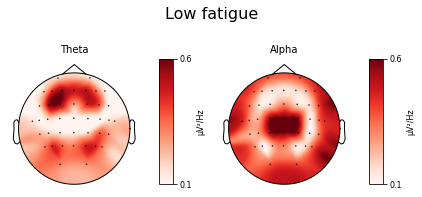

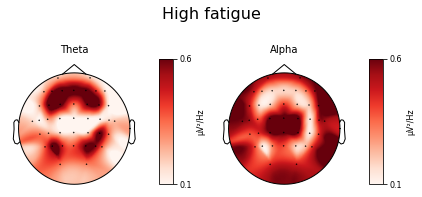

In [15]:
colormap = None
dB = True
normalize = True
vlim = (0.1, 0.6)
bands = [(4, 8, 'Theta'), (8, 12, 'Alpha')]
fig, ax = plt.subplots(1, 2)
fig.suptitle('Low fatigue', fontsize=16, y=0.85)
epochs_sim[int(0.5*N_trials):int(0.75*N_trials)].plot_psd_topomap(
    ch_type='eeg', normalize=normalize, bands=bands,
    cmap=(colormap, True), dB=dB, vlim=vlim, axes=ax);
fig, ax = plt.subplots(1, 2)
fig.suptitle('High fatigue', fontsize=16, y=0.85)
epochs_sim[int(0.75*N_trials):].plot_psd_topomap(ch_type='eeg',
                                                 normalize=normalize,
                                                 bands=bands,
                                                 cmap=(colormap, True), dB=dB,
                                                 vlim=vlim, axes=ax);